In [1]:
!pip install -q rasterio geopandas shapely pyproj fiona


In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point

import rasterio
from rasterio.warp import transform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

## 1. File paths and basic configuration

Update the paths below to point to local copies of the data. The eBird files are tab-separated text files. The noise data are provided as a GeoTIFF for New York.

For this baseline we restrict to a NYC bounding box to keep the
computation small enough for a laptop.


In [3]:
# Colab: mount Google Drive and set base paths

from google.colab import drive
drive.mount('/content/drive')

# Base directories in Drive
# Folder showed in the screenshot:
# /content/drive/MyDrive/AI4C_Project
BASE_DIR = "/content/drive/MyDrive/AI4C_Project"

# eBird NY subset folder (where the txt + codes + annotations.csv live)
# If folder name is slightly different, only change this line.
EBD_DIR = f"{BASE_DIR}/ebd_US-NY_smp_relOct-2025"

# Full paths to the three main data files we need
PATH_EBD_SAMPLING = f"{EBD_DIR}/ebd_US-NY_smp_relOct-2025_sampling.txt"
PATH_EBD_OBS      = f"{EBD_DIR}/ebd_US-NY_smp_relOct-2025.txt"

# Noise raster: inside CONUS_rail_road_and_aviation_noise_2020/State_rasters/
PATH_NOISE_TIF = (
    f"{BASE_DIR}/CONUS_rail_road_and_aviation_noise_2020/"
    "State_rasters/NY_rail_road_and_aviation_noise_2020.tif"
)

ANNOTATIONS_CSV = f"{EBD_DIR}/annotations.csv"

# Analysis configuration

# NYC bounding box in lat/lon
MIN_LAT, MAX_LAT = 40.45, 41.05
MIN_LON, MAX_LON = -74.30, -73.65

# Grid cell size for aggregation
CELL_SIZE_M = 500   # 500 m cells

# Year filter to keep data recent and control file size
MIN_YEAR, MAX_YEAR = 2010, 2024

print("Sampling file :", PATH_EBD_SAMPLING)
print("EBD file      :", PATH_EBD_OBS)
print("Noise raster  :", PATH_NOISE_TIF)
print("Annotations   :", ANNOTATIONS_CSV)


Mounted at /content/drive
Sampling file : /content/drive/MyDrive/AI4C_Project/ebd_US-NY_smp_relOct-2025/ebd_US-NY_smp_relOct-2025_sampling.txt
EBD file      : /content/drive/MyDrive/AI4C_Project/ebd_US-NY_smp_relOct-2025/ebd_US-NY_smp_relOct-2025.txt
Noise raster  : /content/drive/MyDrive/AI4C_Project/CONUS_rail_road_and_aviation_noise_2020/State_rasters/NY_rail_road_and_aviation_noise_2020.tif
Annotations   : /content/drive/MyDrive/AI4C_Project/ebd_US-NY_smp_relOct-2025/annotations.csv


## 2. Load sampling events and filter to NYC

We stream the sampling file in chunks to avoid loading the full
New York eBird file into memory. For each chunk we: 1. Filter by latitude / longitude to stay inside the NYC bounding box.
2. Filter by year (2010–2024).
3. Keep only the columns that we need for this baseline.


In [4]:
smp_usecols = [
    "SAMPLING EVENT IDENTIFIER",
    "LATITUDE",
    "LONGITUDE",
    "OBSERVATION DATE",
    "TIME OBSERVATIONS STARTED",
    "ALL SPECIES REPORTED",
    "DURATION MINUTES",
    "EFFORT DISTANCE KM",
    "EFFORT AREA HA",
    "NUMBER OBSERVERS",
]

sampling_chunks = []

for chunk in pd.read_csv(
    PATH_EBD_SAMPLING,
    sep="\t",
    usecols=smp_usecols,
    parse_dates=["OBSERVATION DATE"],
    chunksize=500_000,
    low_memory=False,
):
    # Geographic filter: NYC bounding box
    m_geo = (
        chunk["LATITUDE"].between(MIN_LAT, MAX_LAT)
        & chunk["LONGITUDE"].between(MIN_LON, MAX_LON)
    )

    # Year filter
    years = chunk.loc[m_geo, "OBSERVATION DATE"].dt.year
    m_year = years.between(MIN_YEAR, MAX_YEAR)

    filtered = chunk.loc[m_geo].loc[m_year].copy()
    sampling_chunks.append(filtered)

sampling = pd.concat(sampling_chunks, ignore_index=True)
print("Sampling events in NYC subset:", len(sampling))
sampling.head()


Sampling events in NYC subset: 860868


,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,SAMPLING EVENT IDENTIFIER,DURATION MINUTES,EFFORT DISTANCE KM,EFFORT AREA HA,NUMBER OBSERVERS,ALL SPECIES REPORTED
0,40.748395,-73.985839,2010-09-25,21:30:00,S6976001,90.0,NaN,NaN,6.0,1
1,40.748395,-73.985839,2010-09-25,21:30:00,S6974532,90.0,NaN,NaN,6.0,1
2,40.748395,-73.985839,2010-09-25,21:30:00,S6974428,90.0,NaN,NaN,6.0,1
3,40.748395,-73.985839,2010-09-25,21:30:00,S6928437,90.0,NaN,NaN,6.0,1
4,40.748395,-73.985839,2010-09-25,21:30:00,S6974292,90.0,NaN,NaN,6.0,1


## 3. Compute species richness per checklist

The EBD observation file has one row per (species, checklist) pair.
Our first step is to compute the number of *distinct* species on each checklist (species richness).

We again stream the file in chunks and keep only the columns we need:
`SAMPLING EVENT IDENTIFIER` and `COMMON NAME`.


In [5]:
obs_usecols = [
    "SAMPLING EVENT IDENTIFIER",
    "COMMON NAME",
]

# Use a set of valid sampling event IDs to reduce work
valid_events = set(sampling["SAMPLING EVENT IDENTIFIER"].unique())

richness_parts = []

for chunk in pd.read_csv(
    PATH_EBD_OBS,
    sep="\t",
    usecols=obs_usecols,
    chunksize=1_000_000,
    low_memory=False,
):
    m = chunk["SAMPLING EVENT IDENTIFIER"].isin(valid_events)
    if not m.any():
        continue

    g = (
        chunk.loc[m]
        .groupby("SAMPLING EVENT IDENTIFIER")["COMMON NAME"]
        .nunique()
    )
    richness_parts.append(g)

# Combine partial results and make a DataFrame
richness_series = pd.concat(richness_parts)
# Some checklists may appear in multiple chunks; take the max
richness_series = richness_series.groupby(level=0).max()

richness = richness_series.reset_index().rename(
    columns={"COMMON NAME": "richness"}
)

print("Checklists with richness estimates:", len(richness))
richness.head()


Checklists with richness estimates: 855929


,SAMPLING EVENT IDENTIFIER,richness
0,S10000020,13
1,S100003873,1
2,S100003883,1
3,S100003889,1
4,S10000422,9


## 4. Join richness back to the sampling events

Now we merge the richness table into the sampling table by `SAMPLING EVENT IDENTIFIER`. Each row now represents a checklist with its location, effort, and species richness.


In [6]:
checklists = sampling.merge(
    richness, on="SAMPLING EVENT IDENTIFIER", how="inner"
)

print("Joined table shape:", checklists.shape)
checklists.head()


Joined table shape: (855929, 11)


,LATITUDE,LONGITUDE,OBSERVATION DATE,TIME OBSERVATIONS STARTED,SAMPLING EVENT IDENTIFIER,DURATION MINUTES,EFFORT DISTANCE KM,EFFORT AREA HA,NUMBER OBSERVERS,ALL SPECIES REPORTED,richness
0,40.748395,-73.985839,2010-09-25,21:30:00,S6976001,90.0,NaN,NaN,6.0,1,11
1,40.748395,-73.985839,2010-09-25,21:30:00,S6974532,90.0,NaN,NaN,6.0,1,11
2,40.748395,-73.985839,2010-09-25,21:30:00,S6974428,90.0,NaN,NaN,6.0,1,8
3,40.748395,-73.985839,2010-09-25,21:30:00,S6928437,90.0,NaN,NaN,6.0,1,11
4,40.748395,-73.985839,2010-09-25,21:30:00,S6974292,90.0,NaN,NaN,6.0,1,11


## 5. Aggregate to 500 m grid cells

To combine eBird with the noise raster we aggregate checklists into regular grid cells.

Steps:

1. Convert the checklist table into a GeoDataFrame in WGS84 (`EPSG:4326`).
2. Project to UTM zone 18N (`EPSG:32618`) so distances are in meters.
3. Assign each point to a grid cell of size 500 m × 500 m.
4. For each cell, compute:
   - Mean species richness (`richness_mean`)
   - Median richness
   - Number of checklists (`n_checklists`)
   - Average latitude and longitude (for plotting and raster sampling)


In [7]:
# Create GeoDataFrame in WGS84
gdf = gpd.GeoDataFrame(
    checklists,
    geometry=gpd.points_from_xy(checklists["LONGITUDE"], checklists["LATITUDE"]),
    crs="EPSG:4326",
)

# Project to UTM 18N
gdf_utm = gdf.to_crs(epsg=32618)

# Compute grid cell indices
x = gdf_utm.geometry.x
y = gdf_utm.geometry.y

gdf_utm["cell_x"] = (x // CELL_SIZE_M).astype(int)
gdf_utm["cell_y"] = (y // CELL_SIZE_M).astype(int)
gdf_utm["cell_id"] = gdf_utm["cell_x"].astype(str) + "_" + gdf_utm["cell_y"].astype(str)

cell_df = (
    gdf_utm.groupby("cell_id")
    .agg(
        richness_mean=("richness", "mean"),
        richness_median=("richness", "median"),
        n_checklists=("richness", "size"),
        lat=("LATITUDE", "mean"),
        lon=("LONGITUDE", "mean"),
    )
    .reset_index()
)

print("Grid cells with at least one checklist:", len(cell_df))
cell_df.head()


Grid cells with at least one checklist: 5327


,cell_id,richness_mean,richness_median,n_checklists,lat,lon
0,1125_8967,5.800000,6.0,5,40.502735,-74.257341
1,1126_8966,28.441959,27.0,1654,40.499509,-74.251675
2,1126_8967,13.852941,15.5,34,40.502398,-74.252309
3,1126_8968,11.928571,12.0,14,40.507122,-74.254503
4,1126_8969,10.152941,11.0,85,40.512052,-74.252893


## 6. Cleaning LAeq values from the noise raster

This cell samples LAeq from the DOT noise raster at each grid cell centroid
and converts obvious **NoData / invalid pixels** to `NaN`. It uses the
raster’s own `nodata` value and also treats any sampled value
with an absolute magnitude larger than 200 as invalid, since realistic transportation noise levels should be well below that threshold.


In [8]:
import numpy as np
import rasterio
from rasterio.warp import transform

with rasterio.open(PATH_NOISE_TIF) as src:

    xs, ys = transform("EPSG:4326", src.crs,
                       cell_df["lon"].values,
                       cell_df["lat"].values)


    samples = list(src.sample(zip(xs, ys)))
    nodata = src.nodata

laeq_vals = []
for v_arr in samples:
    v = float(v_arr[0])


    if nodata is not None and np.isclose(v, nodata):
        laeq_vals.append(np.nan)


    elif abs(v) > 200:
        laeq_vals.append(np.nan)
    else:
        laeq_vals.append(v)

cell_df["laeq"] = laeq_vals

cell_df = cell_df.dropna(subset=["laeq"]).query("n_checklists >= 5").copy()

print("Cells after noise join and filtering:", len(cell_df))
print(cell_df["laeq"].describe())


Cells after noise join and filtering: 2169
count    2169.000000
mean       55.646634
std         9.375390
min        45.005108
25%        48.693558
50%        52.773441
75%        59.257374
max       109.800026
Name: laeq, dtype: float64


## 7. Exploratory analysis

We make a basic scatter plot of LAeq vs mean species richness and
compute the Pearson correlation between them as a first look at the
exposure–response relationship.


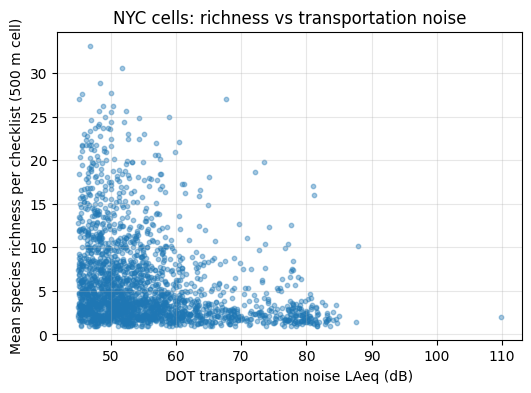

Pearson correlation LAeq vs mean richness: -0.279721651171155


In [9]:
plt.figure(figsize=(6, 4))
plt.scatter(cell_df["laeq"], cell_df["richness_mean"], alpha=0.4, s=10)
plt.xlabel("DOT transportation noise LAeq (dB)")
plt.ylabel("Mean species richness per checklist (500 m cell)")
plt.title("NYC cells: richness vs transportation noise")
plt.grid(True, alpha=0.3)
plt.show()

corr = np.corrcoef(cell_df["laeq"], cell_df["richness_mean"])[0, 1]
print("Pearson correlation LAeq vs mean richness:", corr)


## 8. Baseline linear regression model

We now fit a one-feature linear regression model:

richness_mean_i = beta_0 + beta_noise * LAeq_i + epsilon_i

We split the cells into train and test sets, report R² and RMSE on the
test set, and interpret the noise coefficient.


In [10]:
X = cell_df[["laeq"]].values
y = cell_df["richness_mean"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

# R^2
r2 = r2_score(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

beta_noise = float(linreg.coef_[0])
effect_5db = 5 * beta_noise

print(f"R^2 on held-out cells: {r2:.3f}")
print(f"RMSE on held-out cells: {rmse:.3f} species")
print(f"Noise coefficient beta: {beta_noise:.3f} species per 1 dB")
print(f"Approximate change per 5 dB: {effect_5db:.3f} species")


R^2 on held-out cells: 0.077
RMSE on held-out cells: 5.029 species
Noise coefficient beta: -0.150 species per 1 dB
Approximate change per 5 dB: -0.749 species


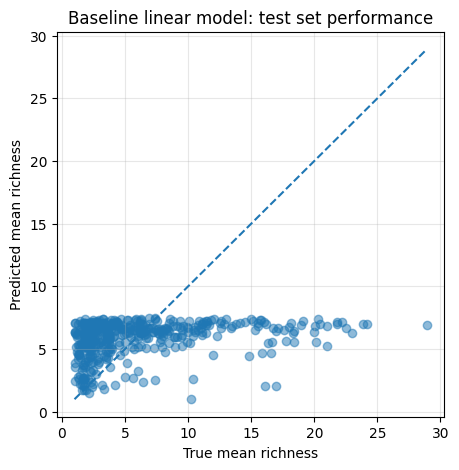

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--")
plt.xlabel("True mean richness")
plt.ylabel("Predicted mean richness")
plt.title("Baseline linear model: test set performance")
plt.grid(True, alpha=0.3)
plt.show()


## 9. figures


1. Histograms showing the distributions of transportation noise (LAeq)
   and mean bird richness across grid cells.
2. A binned noise–richness curve, which smooths the relationship by
   averaging richness within LAeq bins.
3. Simple maps of NYC cells, colored by LAeq and by mean richness,
   to visualize where noisy and species-rich areas are located.


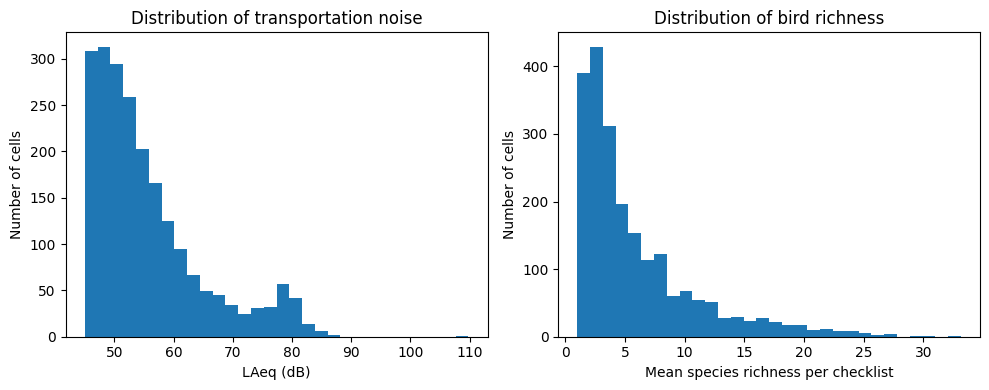

In [12]:
# 1) Histograms of LAeq and mean richness across cells

plt.figure(figsize=(10, 4))

# Histogram of LAeq
plt.subplot(1, 2, 1)
plt.hist(cell_df["laeq"], bins=30)
plt.xlabel("LAeq (dB)")
plt.ylabel("Number of cells")
plt.title("Distribution of transportation noise")

# Histogram of mean richness
plt.subplot(1, 2, 2)
plt.hist(cell_df["richness_mean"], bins=30)
plt.xlabel("Mean species richness per checklist")
plt.ylabel("Number of cells")
plt.title("Distribution of bird richness")

plt.tight_layout()
plt.show()


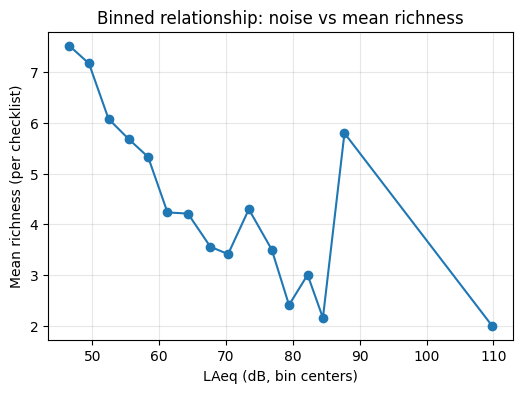

,laeq_center,richness_mean,n_cells
laeq_bin,,,
"(45.004000000000005, 48.005]",46.545826,7.522767,438
"(48.005, 51.005]",49.490656,7.172140,416
"(51.005, 54.005]",52.421552,6.079063,355
"(54.005, 57.005]",55.426676,5.682020,260
"(57.005, 60.005]",58.337919,5.329031,192


In [13]:
# 2) Binned noise–richness curve

# Define LAeq bins
min_laeq = cell_df["laeq"].min()
max_laeq = cell_df["laeq"].max()
bin_width = 3.0   # 3 dB per bin is a common choice

bins = np.arange(min_laeq, max_laeq + bin_width, bin_width)
labels = 0.5 * (bins[:-1] + bins[1:])  # bin centers

cell_df["laeq_bin"] = pd.cut(cell_df["laeq"], bins=bins, include_lowest=True)

binned = (
    cell_df.groupby("laeq_bin", observed=False)
    .agg(
        laeq_center=("laeq", "mean"),
        richness_mean=("richness_mean", "mean"),
        n_cells=("richness_mean", "size"),
    )
    .dropna(subset=["laeq_center"])
)


plt.figure(figsize=(6, 4))
plt.plot(binned["laeq_center"], binned["richness_mean"], marker="o")
plt.xlabel("LAeq (dB, bin centers)")
plt.ylabel("Mean richness (per checklist)")
plt.title("Binned relationship: noise vs mean richness")
plt.grid(True, alpha=0.3)
plt.show()

binned.head()


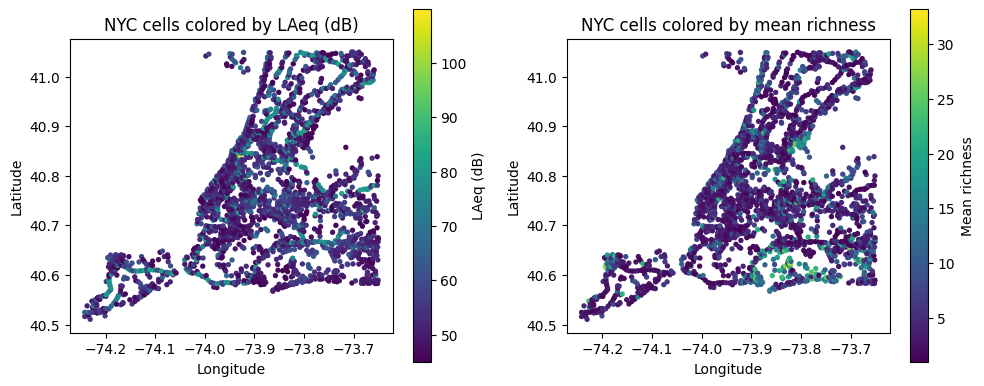

In [14]:
# 3) Simple maps of cells colored by noise and by richness

plt.figure(figsize=(10, 4))

# Map colored by LAeq
plt.subplot(1, 2, 1)
plt.scatter(cell_df["lon"], cell_df["lat"], c=cell_df["laeq"], s=8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("NYC cells colored by LAeq (dB)")
plt.colorbar(label="LAeq (dB)")
plt.gca().set_aspect("equal", adjustable="box")

# Map colored by mean richness
plt.subplot(1, 2, 2)
plt.scatter(cell_df["lon"], cell_df["lat"], c=cell_df["richness_mean"], s=8)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("NYC cells colored by mean richness")
plt.colorbar(label="Mean richness")
plt.gca().set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


In [15]:
# Imports + small helpers
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error

def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def find_candidate_df(target_col="richness_mean", feature_hint="laeq"):
    # Find a DataFrame in globals() that contains needed columns
    candidates = []
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            cols = set(obj.columns)
            if target_col in cols and any(feature_hint.lower() == str(c).lower() for c in cols):
                candidates.append((name, obj))
    return candidates[0] if candidates else (None, None)


In [16]:
# Pick df + choose features/target
target_col = "richness_mean"
default_feature_col = "laeq"

name, df_auto = find_candidate_df(target_col=target_col, feature_hint=default_feature_col)
df = df_auto if df_auto is not None else None

print("Auto-picked df:", name)
if df is None:
    raise ValueError("Could not auto-find a dataframe with columns like 'richness_mean' and 'laeq'. "
                     "Set df = <dataframe_name> manually in this cell.")

feature_cols = [default_feature_col]  # e.g., ["laeq"] or ["laeq", "ndvi", "evi", "dist_road", ...]
feature_cols = [c for c in feature_cols if c in df.columns]

# Basic cleaning
work = df[feature_cols + [target_col]].copy()
work = work.replace([np.inf, -np.inf], np.nan).dropna()

X = work[feature_cols].values
y = work[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Rows used:", len(work), "| Features:", feature_cols, "| Target:", target_col)


Auto-picked df: cell_df
Rows used: 2169 | Features: ['laeq'] | Target: richness_mean


In [17]:
# Define models
models = [
    ("Linear", "Global linear",
     Pipeline([("lr", LinearRegression())]),
     "Baseline"),

    ("Polynomial (deg=2)", "Global curved",
     Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),
               ("lr", LinearRegression())]),
     "Adds nonlinearity in LAeq"),

    ("KNN (k=15)", "Local, instance",
     Pipeline([("scaler", StandardScaler()),
               ("knn", KNeighborsRegressor(n_neighbors=15))]),
     "Uses nearby points in feature space"),

    ("Random Forest", "Tree ensemble",
     RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
     "Nonlinear, interpretable"),

    ("Gradient Boosted Trees", "Tree ensemble",
     GradientBoostingRegressor(random_state=42),
     "Often strongest model"),

    # ---- Extra models (for more comparison) ----
    ("Extra Trees", "Tree ensemble",
     ExtraTreesRegressor(n_estimators=600, random_state=42, n_jobs=-1),
     "More randomized trees; often strong"),

    ("Ridge", "Linear regularized",
     Pipeline([("scaler", StandardScaler()),
               ("ridge", Ridge(alpha=1.0, random_state=42))]),
     "Stable linear baseline"),

    ("Lasso", "Linear regularized",
     Pipeline([("scaler", StandardScaler()),
               ("lasso", Lasso(alpha=0.01, random_state=42, max_iter=20000))]),
     "Sparse linear model"),

    ("ElasticNet", "Linear regularized",
     Pipeline([("scaler", StandardScaler()),
               ("enet", ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=20000))]),
     "Blend of L1/L2"),

    ("SVR (RBF)", "Kernel method",
     Pipeline([("scaler", StandardScaler()),
               ("svr", SVR(C=10.0, epsilon=0.1, gamma="scale"))]),
     "Nonlinear in 1D too; can work well"),
]


In [18]:
# Train + evaluate (test metrics + optional CV)
do_cv = True
cv_splits = 5

rows = []
for model_name, model_type, model, note in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    r2 = float(r2_score(y_test, pred))
    rmse = _rmse(y_test, pred)

    out = {
        "Model": model_name,
        "Type": model_type,
        "R2_test": r2,
        "RMSE_test": rmse,
        "Notes": note
    }

    if do_cv:
        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
        scores = cross_validate(
            model, X, y,
            cv=cv,
            scoring={"r2": "r2", "neg_rmse": "neg_root_mean_squared_error"},
            n_jobs=-1
        )
        out["R2_cv_mean"] = float(np.mean(scores["test_r2"]))
        out["RMSE_cv_mean"] = float(-np.mean(scores["test_neg_rmse"]))

    rows.append(out)

results = pd.DataFrame(rows).sort_values("RMSE_test")
results


,Model,Type,R2_test,RMSE_test,Notes,R2_cv_mean,RMSE_cv_mean
1,Polynomial (deg=2),Global curved,0.087737,4.998467,Adds nonlinearity in LAeq,0.079037,4.848492
0,Linear,Global linear,0.076666,5.028706,Baseline,0.075288,4.858485
6,Ridge,Linear regularized,0.076663,5.028716,Stable linear baseline,0.075289,4.858484
7,Lasso,Linear regularized,0.076618,5.028837,Sparse linear model,0.075292,4.858487
8,ElasticNet,Linear regularized,0.076608,5.028866,Blend of L1/L2,0.075294,4.858486
4,Gradient Boosted Trees,Tree ensemble,0.031825,5.149368,Often strongest model,0.014967,5.015113
2,KNN (k=15),"Local, instance",0.017611,5.187030,Uses nearby points in feature space,-0.004382,5.063074
9,SVR (RBF),Kernel method,-0.038128,5.332151,Nonlinear in 1D too; can work well,-0.026353,5.119255
3,Random Forest,Tree ensemble,-0.478099,6.362513,"Nonlinear, interpretable",-0.401533,5.980846
5,Extra Trees,Tree ensemble,-0.665023,6.752849,More randomized trees; often strong,-0.649511,6.485486


In [19]:
# pick best
pd.set_option("display.max_colwidth", 60)

best = results.iloc[0]
print("Best (by RMSE_test):")
print(best[["Model", "R2_test", "RMSE_test"]].to_string())

table_like = results[["Model", "Type", "R2_test", "RMSE_test", "Notes"]].copy()
table_like


Best (by RMSE_test):
Model        Polynomial (deg=2)
R2_test                0.087737
RMSE_test              4.998467


,Model,Type,R2_test,RMSE_test,Notes
1,Polynomial (deg=2),Global curved,0.087737,4.998467,Adds nonlinearity in LAeq
0,Linear,Global linear,0.076666,5.028706,Baseline
6,Ridge,Linear regularized,0.076663,5.028716,Stable linear baseline
7,Lasso,Linear regularized,0.076618,5.028837,Sparse linear model
8,ElasticNet,Linear regularized,0.076608,5.028866,Blend of L1/L2
4,Gradient Boosted Trees,Tree ensemble,0.031825,5.149368,Often strongest model
2,KNN (k=15),"Local, instance",0.017611,5.187030,Uses nearby points in feature space
9,SVR (RBF),Kernel method,-0.038128,5.332151,Nonlinear in 1D too; can work well
3,Random Forest,Tree ensemble,-0.478099,6.362513,"Nonlinear, interpretable"
5,Extra Trees,Tree ensemble,-0.665023,6.752849,More randomized trees; often strong


In [21]:
# C1 sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)

r2_dummy = r2_score(y_test, pred_dummy)
rmse_dummy = np.sqrt(mean_squared_error(y_test, pred_dummy))

print(f"Dummy(mean)  R2_test={r2_dummy:.6f}  RMSE_test={rmse_dummy:.6f}")

if "results" in globals():
    add_row = {
        "Model": "Dummy(mean)",
        "Type": "Baseline",
        "R2_test": float(r2_dummy),
        "RMSE_test": float(rmse_dummy),
        "Notes": "Predicts training mean",
    }
    if "R2_cv_mean" in results.columns:
        add_row["R2_cv_mean"] = np.nan
    if "RMSE_cv_mean" in results.columns:
        add_row["RMSE_cv_mean"] = np.nan

    results_with_dummy = pd.concat([results, pd.DataFrame([add_row])], ignore_index=True)
    display(results_with_dummy.sort_values("RMSE_test"))


Dummy(mean)  R2_test=-0.001466  RMSE_test=5.237151


,Model,Type,R2_test,RMSE_test,Notes,R2_cv_mean,RMSE_cv_mean
0,Polynomial (deg=2),Global curved,0.087737,4.998467,Adds nonlinearity in LAeq,0.079037,4.848492
1,Linear,Global linear,0.076666,5.028706,Baseline,0.075288,4.858485
2,Ridge,Linear regularized,0.076663,5.028716,Stable linear baseline,0.075289,4.858484
3,Lasso,Linear regularized,0.076618,5.028837,Sparse linear model,0.075292,4.858487
4,ElasticNet,Linear regularized,0.076608,5.028866,Blend of L1/L2,0.075294,4.858486
5,Gradient Boosted Trees,Tree ensemble,0.031825,5.149368,Often strongest model,0.014967,5.015113
6,KNN (k=15),"Local, instance",0.017611,5.187030,Uses nearby points in feature space,-0.004382,5.063074
10,Dummy(mean),Baseline,-0.001466,5.237151,Predicts training mean,NaN,NaN
7,SVR (RBF),Kernel method,-0.038128,5.332151,Nonlinear in 1D too; can work well,-0.026353,5.119255
8,Random Forest,Tree ensemble,-0.478099,6.362513,"Nonlinear, interpretable",-0.401533,5.980846


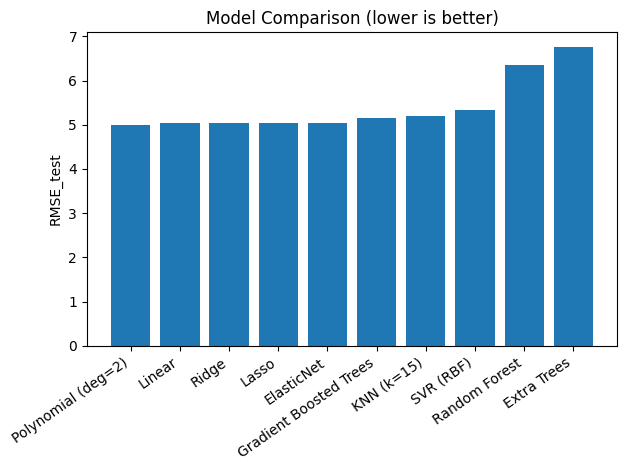

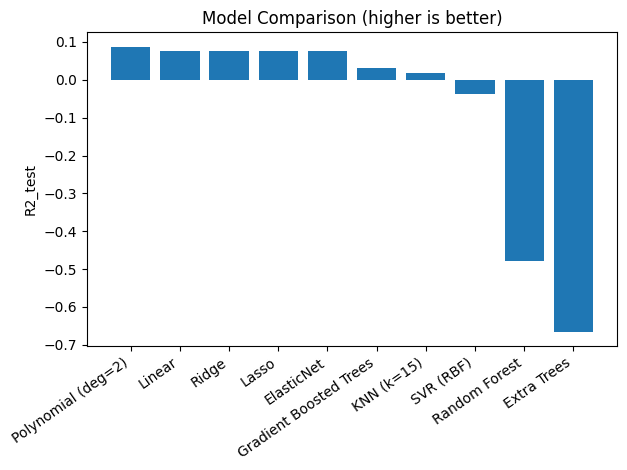

In [22]:
# Bar charts: RMSE_test and R2_test
import matplotlib.pyplot as plt

res = results.sort_values("RMSE_test").copy()

plt.figure()
plt.bar(res["Model"], res["RMSE_test"])
plt.xticks(rotation=35, ha="right")
plt.ylabel("RMSE_test")
plt.title("Model Comparison (lower is better)")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(res["Model"], res["R2_test"])
plt.xticks(rotation=35, ha="right")
plt.ylabel("R2_test")
plt.title("Model Comparison (higher is better)")
plt.tight_layout()
plt.show()


In [23]:
# C3 — Refit selected models for plotting
from sklearn.base import clone

model_dict = {name: model for (name, _type, model, _note) in models}

topk = 4
top_models = results.sort_values("RMSE_test")["Model"].head(topk).tolist()
if "Linear" in model_dict and "Linear" not in top_models:
    top_models.append("Linear")

fitted = {}
for m in top_models:
    if m in model_dict:
        fitted[m] = clone(model_dict[m]).fit(X_train, y_train)

print("Models plotted:", list(fitted.keys()))

Models plotted: ['Polynomial (deg=2)', 'Linear', 'Ridge', 'Lasso']


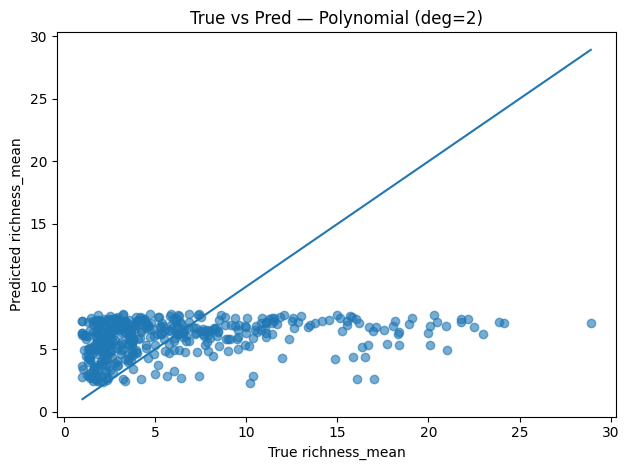

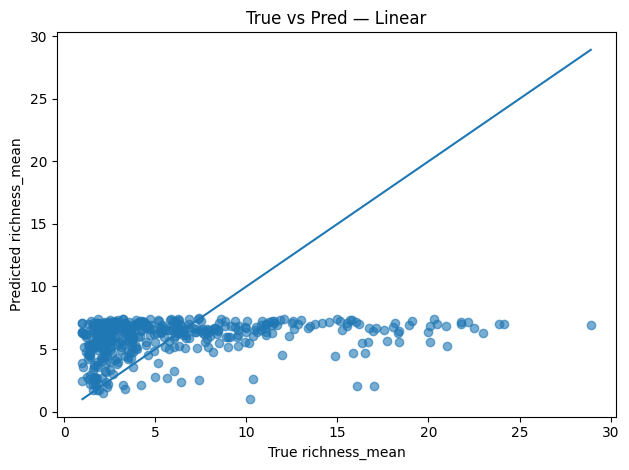

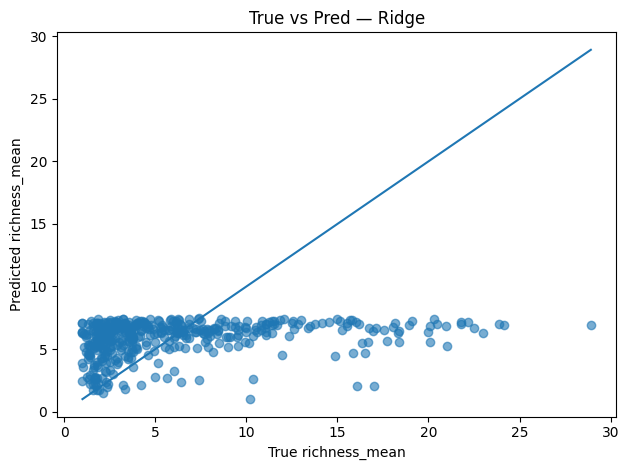

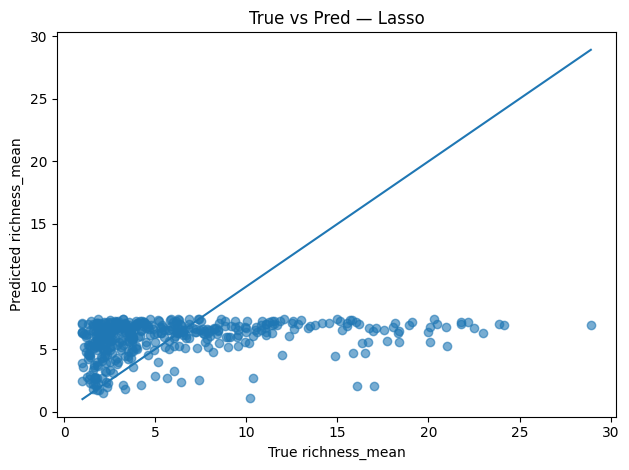

In [24]:
# C4 — True vs Pred scatter (y = x reference)
import numpy as np
import matplotlib.pyplot as plt

for m, mdl in fitted.items():
    y_pred = mdl.predict(X_test)

    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.6)
    lo = min(np.min(y_test), np.min(y_pred))
    hi = max(np.max(y_test), np.max(y_pred))
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True richness_mean")
    plt.ylabel("Predicted richness_mean")
    plt.title(f"True vs Pred — {m}")
    plt.tight_layout()
    plt.show()


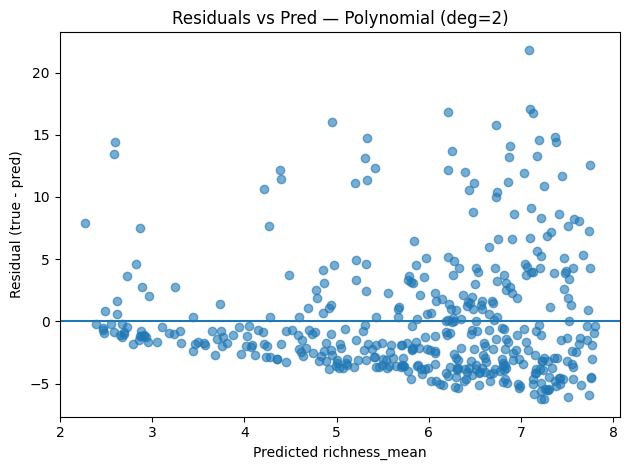

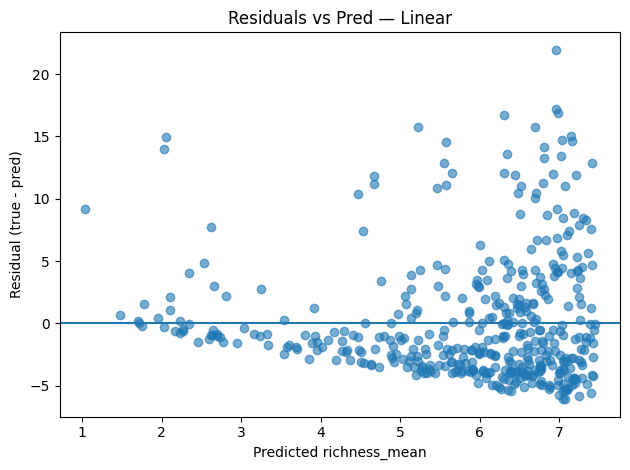

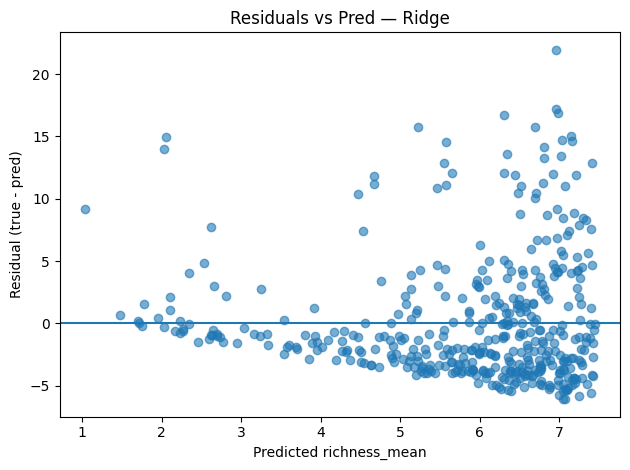

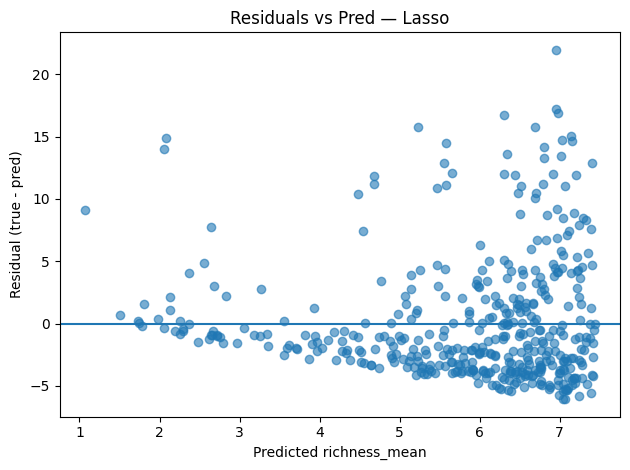

In [25]:
# C5 — Residuals vs Pred
import matplotlib.pyplot as plt

for m, mdl in fitted.items():
    y_pred = mdl.predict(X_test)
    resid = y_test - y_pred

    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Predicted richness_mean")
    plt.ylabel("Residual (true - pred)")
    plt.title(f"Residuals vs Pred — {m}")
    plt.tight_layout()
    plt.show()


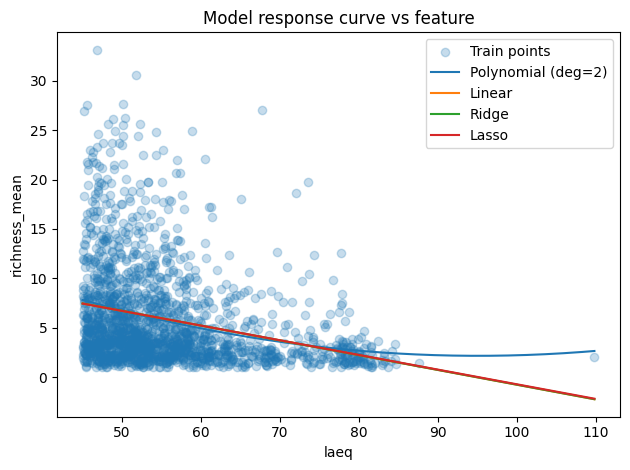

In [26]:
# C6 — Response curve
import numpy as np
import matplotlib.pyplot as plt

if len(feature_cols) == 1:
    x_train_1d = X_train[:, 0]
    x_grid = np.linspace(x_train_1d.min(), x_train_1d.max(), 250).reshape(-1, 1)

    plt.figure()
    plt.scatter(X_train[:, 0], y_train, alpha=0.25, label="Train points")

    for m, mdl in fitted.items():
        y_grid = mdl.predict(x_grid)
        plt.plot(x_grid[:, 0], y_grid, label=m)

    plt.xlabel(feature_cols[0])
    plt.ylabel(target_col)
    plt.title("Model response curve vs feature")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipped: response curve only supported for 1 feature.")
